## 7-3. HHLアルゴリズムを用いたポートフォリオ最適化
この節では論文[1]を参考に、過去の株価変動のデータから、最適なポートフォリオ（資産配分）を計算してみよう。
ポートフォリオ最適化は、[7-1節](7.1_quantum_phase_estimation_detailed.ipynb)で学んだHHLアルゴリズムを用いることで、従来より高速に解けることが期待されている問題の一つである。
今回は具体的に、GAFA (Google, Apple, Facebook, Amazon) の4社の株式に投資する際、どのような資産配分を行えば最も低いリスクで高いリターンを得られるかという問題を考える。

### 株価データ取得
まずは各社の株価データを取得する。

* GAFA 4社の日次データを用いる
* 株価データ取得のためにpandas_datareaderを用いてYahoo! Financeのデータベースから取得
* 株価はドル建ての調整後終値（Adj. Close）を用いる

In [1]:
# データ取得に必要なpandas, pandas_datareaderのインストール
!pip install pandas pandas_datareader

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

from qiskit import Aer
from qiskit.circuit.library import QFT
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms import HHL, NumPyLSsolver
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.initial_states import Custom

In [3]:
# 銘柄選択
codes = ['GOOG', 'AAPL', 'FB', 'AMZN'] # GAFA

# 2017年の1年間のデータを使用
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2017, 12, 31)

# Yahoo! Financeから日次の株価データを取得
data = web.DataReader(codes, 'yahoo', start, end)

df = data['Adj Close'] 

## 直近のデータの表示
display(df.tail())

Symbols,GOOG,AAPL,FB,AMZN
Date,,,,
2017-12-22,1060.119995,42.103676,177.199997,1168.359985
2017-12-26,1056.739990,41.035507,175.990005,1176.760010
2017-12-27,1049.369995,41.042721,177.619995,1182.260010
2017-12-28,1048.140015,41.158192,177.919998,1186.099976
2017-12-29,1046.400024,40.713127,176.460007,1169.469971


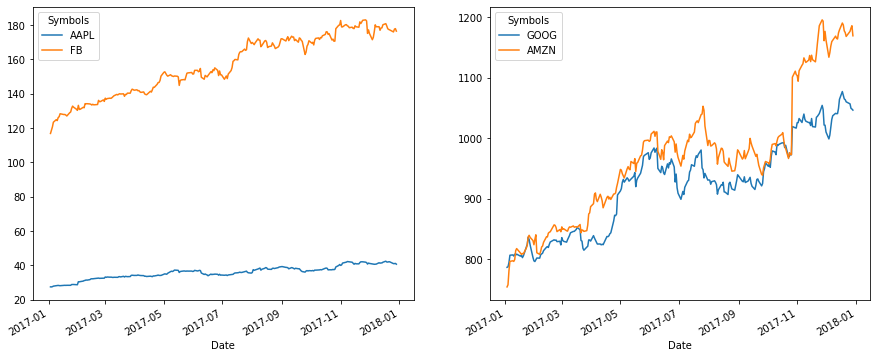

In [4]:
## 株価をプロットしてみる
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
df.loc[:,['AAPL', 'FB']].plot(ax=axes[0])
df.loc[:,['GOOG', 'AMZN']].plot(ax=axes[1])

※ここで、4つの銘柄を2つのグループに分けているのは、株価の値がそれぞれ近くプロット時に見やすいからであり、深い意味はない。

### データの前処理
次に、取得した株価を日次リターンに変換し、いくつかの統計量を求めておく。

#### 日次リターンへの変換
個別銘柄の日次リターン（変化率） $y_t$ （$t$は日付）は以下で定義される。 

$$
y_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

これは `pandas DataFrame` の `pct_change()` メソッドで得られる。

In [5]:
daily_return = df.pct_change()
display(daily_return.tail())

Symbols,GOOG,AAPL,FB,AMZN
Date,,,,
2017-12-22,-0.003300,0.000000,-0.001409,-0.005448
2017-12-26,-0.003188,-0.025370,-0.006828,0.007190
2017-12-27,-0.006974,0.000176,0.009262,0.004674
2017-12-28,-0.001172,0.002813,0.001689,0.003248
2017-12-29,-0.001660,-0.010814,-0.008206,-0.014021


#### 期待リターン
銘柄ごとの期待リターン$\vec R$を求める。ここでは過去のリターンの算術平均を用いる：

$$
\vec R = \frac{1}{T} \sum_{t= 1}^{T} \vec y_t
$$

In [6]:
expected_return = daily_return.dropna(how='all').mean() * 252 # 年率換算のため年間の営業日数252を掛ける
print(expected_return)

Symbols
GOOG    0.300215
AAPL    0.411191
FB      0.430156
AMZN    0.464567
dtype: float64


#### 分散・共分散行列
リターンの標本不偏分散・共分散行列$\Sigma$は以下で定義される。

$$
\Sigma = \frac{1}{T-1} \sum_{t=1}^{T} ( \vec y_t -\vec R ) (\vec y_t -\vec R )^T
$$

In [7]:
cov = daily_return.dropna(how='all').cov() * 252 # 年率換算のため
display(cov)

Symbols,GOOG,AAPL,FB,AMZN
Symbols,,,,
GOOG,0.023690,0.013303,0.018382,0.021614
AAPL,0.013303,0.031119,0.016291,0.018877
FB,0.018382,0.016291,0.028855,0.023337
AMZN,0.021614,0.018877,0.023337,0.044120


### ポートフォリオ最適化
準備が整ったところで、ポートフォリオ最適化に取り組もう。

まず、ポートフォリオ（i.e., 資産配分）を4成分のベクトル $\vec{w} = (w_0,w_1,w_2,w_3)^T$ で表す。
これは各銘柄を持つ割合（ウェイト）を表しており、例えば $\vec{w}=(1,0,0,0)$ であれば Google 株に全資産の100%を投入しするポートフォリオを意味する。

以下の式を満たすようなポートフォリオを考えてみよう。

$$
\min_{\vec{w}} \frac{1}{2} \vec{w}^T \Sigma \vec{w} \:\:\: \text{s.t.} \:\: \vec R^T \vec w = \mu , \: \vec 1^T \vec w =1
$$

この式は

* 「ポートフォリオの期待リターン（リターンの平均値）が$\mu$ 」
* 「ポートフォリオに投資するウェイトの合計が1」（$\vec 1 = (1,1,1,1)^T$）

という条件の下で、

* 「ポートフォリオのリターンの分散の最小化」

を行うことを意味している。つまり、将来的に $\mu$ だけのリターンを望む時に、なるべくその変動（リスク）を小さくするようなポートフォリオが最善だというわけである。このような問題設定は、[Markowitzの平均分散アプローチ](https://ja.wikipedia.org/wiki/現代ポートフォリオ理論)と呼ばれ、現代の金融工学の基礎となる考えの一つである。

ラグランジュの未定乗数法を用いると、上記の条件を満たす$\vec{w}$は、線形方程式

$$
\begin{gather}
W
\left( 
\begin{array}{c}
\eta \\
\theta \\
\vec w
\end{array}
\right)
=
\left( 
\begin{array}{c}
 \mu \\
 1 \\
\vec 0
\end{array}
\right),  \tag{1}\\
W =
\left( 
\begin{array}{ccc}
0 & 0 & \vec R^T \\
0 & 0 & \vec 1^T \\
\vec{R} &\vec 1 & \Sigma 
\end{array}
\right) 
\end{gather}
$$

を解くことで得られる事がわかる。
ここで $\eta, \theta$ はラグランジュの未定乗数法のパラメータである。
したがって、最適なポートフォリオ $\vec w$ を求めるためには、連立方程式(1)を $\vec w$ について解けば良いことになる。
これで、ポートフォリオ最適化問題をHHLアルゴリズムが使える線形一次方程式に帰着できた。

#### 行列Wの作成

In [8]:
R = expected_return.values
Pi = np.ones(4)
S = cov.values

row1 = np.append(np.zeros(2), R).reshape(1,-1)
row2 = np.append(np.zeros(2), Pi).reshape(1,-1)
row3 = np.concatenate([R.reshape(-1,1), Pi.reshape(-1,1), S], axis=1)
W = np.concatenate([row1, row2, row3])

np.set_printoptions(linewidth=200)
print(W)

[[0.         0.         0.30021458 0.4111914  0.43015563 0.46456748]
 [0.         0.         1.         1.         1.         1.        ]
 [0.30021458 1.         0.02369003 0.01330327 0.01838175 0.0216144 ]
 [0.4111914  1.         0.01330327 0.03111908 0.01629125 0.01887662]
 [0.43015563 1.         0.01838175 0.01629125 0.02885482 0.02333747]
 [0.46456748 1.         0.0216144  0.01887662 0.02333747 0.04412049]]


In [9]:
## Wの固有値を確認 -> [-pi, pi] に収まっている
print(np.linalg.eigh(W)[0])

[-2.11207191 -0.10947985  0.01121934  0.01864266  0.11919723  2.20027694]


#### 右辺ベクトルの作成
以下でポートフォリオの期待リターン $\mu$ を指定すると、そのようなリターンをもたらす最もリスクの小さいポートフォリオを計算できる。$\mu$ は自由に設定できる。一般に期待リターンが大きいほどリスクも大きくなるが、ここでは例として10%としておく（GAFA株がガンガン上がっている時期なので、これはかなり弱気な方である）。

In [10]:
mu = 0.1 # ポートフォリオのリターン（手で入れるパラメータ）
xi = 1.0 
mu_xi_0 = np.append(np.array([mu, xi]), np.zeros_like(R)) ## (1)式の右辺のベクトル
print(mu_xi_0)

[0.1 1.  0.  0.  0.  0. ]


#### 量子系で扱えるように行列を拡張する
$W$ は6次元なので、3量子ビットあれば量子系で計算可能である ($2^3 = 8$)。
そこで、拡張した2次元分を0で埋めた行列とベクトルも作っておく。

In [11]:
matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(W, mu_xi_0)

Input matrix does not have dimension 2**n. It will be expanded automatically.


以上で、連立方程式(1)を解く準備が整った。

### HHLアルゴリズムを用いた最小分散ポートフォリオ算出
それでは、HHL アルゴリズムを用いて、連立一次方程式(1)を解いていこう。
先ずはその下準備として、

* 古典データ $\mathbf{x}$ に応じて、量子状態を $|0\cdots0\rangle \to \sum_i x_i |i \rangle$ と変換する量子回路を返す関数 `input_state_gate` （本来は qRAM の考え方を利用して作るべきだが、シミュレータを使っているので今回は non-unitary なゲートとして実装してしまう。また、規格化は無視している)
* 制御位相ゲートを返す関数 `CPhaseGate`
* 量子フーリエ変換を行うゲートを返す関数 `QFT_gate` 

を用意する。

In [12]:
def create_eigs(matrix, num_ancillae, num_time_slices, negative_evals):
    ne_qfts = [None, None]
    if negative_evals:
        num_ancillae += 1
        # The QFT and IQFT circuits for handling negative eigenvalues
        ne_qfts = [QFT(num_ancillae - 1), QFT(num_ancillae - 1).inverse()]

    """
    Specifically, this class is based on PhaseEstimationCircuit with no measurements 
    and has additional handling of negative eigenvalues
    """
    return EigsQPE(MatrixOperator(matrix=matrix),
                   QFT(num_ancillae).inverse(),
                   num_time_slices=num_time_slices,
                   num_ancillae=num_ancillae,
                   expansion_mode='suzuki',
                   expansion_order=2,
                   evo_time=None,  # This is t, can set to: np.pi*3/4
                   negative_evals=negative_evals,
                   ne_qfts=ne_qfts)

In [13]:
orig_size = len(vector)

# Initialize eigenvalue finding module
eigs = create_eigs(matrix, 7, 50, False)
num_q, num_a = eigs.get_register_sizes()

# Initialize initial state module
init_state = Custom(num_q, state_vector=vector)

# Initialize reciprocal rotation module
reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time)

In [14]:
algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs, init_state, reci, num_q, num_a, orig_size)

HHL アルゴリズムによる解 `x_HHL` と、通常の古典計算の対角化による解 `x_exact` を比べると、概ね一致していることが分かる。（HHLアルゴリズムの精度を決めるパラメータはいくつかある（例えば`reg_nbit`）ので、それらを変えて色々試してみて頂きたい。）

In [ ]:
## 結果
x_HHL = algo.run(QuantumInstance(Aer.get_backend('statevector_simulator')))

In [ ]:
## 厳密解
x_exact = np.linalg.lstsq(matrix, vector, rcond=0)[0]

print("HHL:  ", x_HHL.solution)
print("exact:", x_exact)
rel_error = np.linalg.norm(x_HHL.solution- x_exact) / np.linalg.norm(x_exact)
print("rel_error", rel_error)

実際のウェイトの部分だけ取り出すと

In [ ]:
w_opt_HHL = x_HHL.solution[2:6] 
w_opt_exact = x_exact[2:6] 
w_opt = pd.DataFrame(np.vstack([w_opt_exact, w_opt_HHL]).T, index=df.columns, columns=['exact', 'HHL'])
w_opt

In [ ]:
w_opt.plot.bar()

※重みが負になっている銘柄は、「空売り」（株を借りてきて売ること。株価が下がる局面で利益が得られる手法）を表す。今回は目標リターンが10%と、GAFA株（単独で30〜40%の期待リターン）にしてはかなり小さい値を設定したため、空売りを行って全体の期待リターンを下げていると思われる。

### Appendix: バックテスト
過去のデータから得られた投資ルールを、それ以降のデータを用いて検証することを「バックテスト」と呼び、その投資ルールの有効性を測るために重要である。
ここでは以上のように2017年のデータから構築したポートフォリオに投資した場合に、翌年の2018年にどの程度資産価値が変化するかを観察する。

In [ ]:
# 2018年の1年間のデータを使用
start = datetime.datetime(2017, 12, 30)
end = datetime.datetime(2018, 12, 31)

# Yahoo! Financeから日次の株価データを取得
data = web.DataReader(codes, 'yahoo', start, end)

df2018 = data['Adj Close'] 

display(df2018.tail())

In [ ]:
## 株価をプロットしてみる
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
df2018.loc[:,['AAPL', 'FB']].plot(ax=axes[0])
df2018.loc[:,['GOOG', 'AMZN']].plot(ax=axes[1])

In [ ]:
# ポートフォリオの資産価値の推移
pf_value = df2018.dot(w_opt)
pf_value.head()

In [ ]:
# exact と HHLで初期金額が異なることがありうるので、期初の値で規格化したリターンをみる。
pf_value.exact = pf_value.exact / pf_value.exact[0] 
pf_value.HHL = pf_value.HHL / pf_value.HHL[0] 
print(pf_value.tail())

In [ ]:
pf_value.plot(figsize=(9, 6))

2018年はAmazon以外のGAFA各社の株式が軟調だったので、およそ-20%もの損が出ているが、exact解の方は多少マシであるようだ。。
ちなみに、元々行ったのはリスク最小化なので、この一年間のリスクも計算してみると、exact解の方が小さい結果となった。

In [ ]:
pf_value.pct_change().std() * np.sqrt(252) ## 年率換算

### 参考文献
[1] P. Rebentrost and S. Lloyd, “Quantum computational finance: quantum algorithm for portfolio optimization“, https://arxiv.org/abs/1811.03975